In [1]:
import argparse
import tensorflow as tf
import numpy as np
from utils.classifier import Classifier
from utils import transd_process
from utils import hop_utils as hopu
from utils import sp_utils as spu
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import pysnooper
import warnings
warnings.filterwarnings('ignore')
import math

### 参数设置

In [2]:
def parse_args():
    '''
    Parses the arguments.
    '''
    parser = argparse.ArgumentParser(description="Run GARNS.")

    parser.add_argument('--dataset', nargs='?', default='cora',  #cora  #pubmed citeseer
                        help='Input dataset')

    parser.add_argument('--lr', type=float, default=0.0001,
                        help='Learning rate. Default is 0.0001.')

    parser.add_argument('--n-epochs', default=200, type=int,
                        help='Number of epochs')

    parser.add_argument('--hidden_dims', type=list, nargs='+', default=[512, 128],
                        help='Number of dimensions.')



    parser.add_argument('--K', default=2,type=int,
                        help='k-hops')   
    parser.add_argument('--beta', default=0.5, type=int,
                        help='beta') 

    parser.add_argument('--seed', default=1, type=int,
                        help='seed')        
    #return parser.parse_args()
    return parser.parse_args(args=[]) # jupyter 使用paraer的方法 必须(args=[])
#调用
args = parse_args()  
print(args)

Namespace(K=2, beta=0.5, dataset='cora', hidden_dims=[512, 128], lr=0.0002, n_epochs=400, seed=1)


### 加载数据

In [3]:
adj, X, Y, idx_train, idx_val, idx_test,X_target = transd_process.load_data(args.dataset)


In [4]:
#观察数据
print(X.shape,Y.shape,type(X),type(X_target),type(Y), Y.shape)
print(type(adj),adj.shape)
print(idx_train)
print(idx_val)
print(len(idx_test))
print(len(adj.row)/2)

(2708, 1433) (2708, 7) <class 'numpy.matrix'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> (2708, 7)
<class 'scipy.sparse.coo.coo_matrix'> (2708, 2708)
range(0, 140)
range(140, 640)
1000
5278.0


In [5]:
# prepare the data
adj_tf, row,col = transd_process.prepare_graph_data(adj)
print(type(adj_tf),type(row),type(col))
print(adj_tf)
print(row)
print(col)

<class 'tuple'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
(array([[   0,    0],
       [   0,  633],
       [   0, 1862],
       ...,
       [2707, 1473],
       [2707, 2706],
       [2707, 2707]], dtype=int32), array([1., 1., 1., ..., 1., 1., 1.], dtype=float32), (2708, 2708))
[   0  633 1862 ... 1473 2706 2707]
[   0    0    0 ... 2707 2707 2707]


In [6]:
F =X
inputs = X #
#inputs = np.concatenate((X,adj.todense()),axis = 1)
#d = np.sum(adj.A,axis=1)
#ones = np.eye(adj.A.shape[0])
#d = ones*d
#inputs = np.concatenate((X,d),axis = 1)

# 隐藏层
#feature_dim = X.shape[1]
#args.hidden_dims = [feature_dim] + args.hidden_dims
# 连接属性个数(为第一层的输入个数) 和隐藏层
args.hidden_dims = [inputs.shape[1]] + args.hidden_dims
print(args.hidden_dims)

[1433, 512, 128]


In [7]:
TA = adj
TA.tolil().A

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 1, 0]], dtype=int64)

In [8]:
hops = hopu.get_hops(adj, 2)
NS = hops[1]  # 1阶

neighbours=[]  #与inputs_labels中值为节点编号的每个节点的1阶邻居节点,
degree=[]      #以下标为编号的每个节点的度
for i in range(len(NS.rows)):
    degree.append(len(NS.rows[i]))
    for j in range(len(NS.rows[i])):
        neighbours.append(NS.rows[i][j])
input_label = [i for i in range(adj.shape[0])]
neighbours = np.expand_dims(np.array(neighbours),axis=1)
inputs_label = np.repeat(input_label,degree)  # 每个节点按其度数重复
print(neighbours.shape)
print(inputs_label.shape)
print(len(degree))


(10556, 1)
(10556,)
2708


### Model

In [9]:


class GARNS():
    # A 是邻接矩阵,F是特征矩阵
    def __init__(self, args, A,F):
        tf.reset_default_graph()
        tf.set_random_seed(args.seed)
        np.random.seed(args.seed)
        
        self.args = args
        self.A_dense = tf.cast(A.A, tf.float32)
        self.F = tf.cast(F,tf.float32)
     
        self.layers_n = len(args.hidden_dims)

        self.f_shape = self.F.shape        #特征矩阵的shape
        self.a_shape = self.A_dense.shape  # 邻接矩阵的sahpe

        self.build_placeholders()
        
        hops = hopu.get_hops(A, args.K)
        
        NS = hops[1]

        self.degrees=[]
        for i in range(len(NS.rows)):
            #以下标为编号的每个节点的度
            self.degrees.append(len(NS.rows[i]))

        '''
        scale_terms为k-hops邻居节点个数的dict,其中scale_terms[max(hops.keys()) + 1] 
        为按节点号为顺序号的节点 不可达的节点数
        '''
        scale_terms = {h if h != -1 else max(hops.keys()) + 1:
                           hops[h].sum(1).A1 if h != -1 else hops[1].shape[0] - hops[h].sum(1).A1
                       for h in hops}
        
        
        self.__dataset_generator(hops, scale_terms)       
        self.build_model()
        self.build_loss()

    def build_placeholders(self):

        #邻接矩阵的输入
        self.A = tf.sparse_placeholder(tf.float32, shape=self.a_shape, name='adjacency')

        #特征矩阵的输入
        self.inputs = tf.placeholder(dtype=tf.float32,\
                                    #shape=[self.a_shape[0],self.a_shape[1]+self.f_shape[1]])  
                                    shape=[self.a_shape[0],self.f_shape[1]])
                                     
                                    
        self.neighbours = tf.placeholder(tf.int64, shape=[None, 1])
        self.inputs_label = tf.placeholder(dtype=tf.int64)
        self.row = tf.placeholder(tf.int64)
        self.col = tf.placeholder(tf.int64)          
        
    @pysnooper.snoop()    
    def build_model(self):
        def __decoder(H,de_hidden_dims,layers_n):

            for i in range(1,layers_n ):
                H = tf.layers.dense(H,de_hidden_dims[i],activation=tf.nn.relu,use_bias=False) # 默认 ,use_bias=True
            return H
        H = self.inputs   #特征矩阵
        E = self.A_dense  #邻接矩阵
        N_class = self.a_shape[0].value
        zz = type(N_class)
        en_dims = self.args.hidden_dims[:]
        de_dims = self.args.hidden_dims[:]
        de_dims.reverse()
        # encoder
        for i in range(1,self.layers_n): 
            H = tf.layers.dense(H,en_dims[i],activation=tf.nn.relu,use_bias=False)
        # 经过多层全连接神网络后的结果,与最终的嵌入表达维数一致
        Z = H

        # construct variables for nce loss
        nce_weights = tf.Variable(tf.truncated_normal([N_class,self.args.hidden_dims[-1]],\
            stddev=1.0/math.sqrt(self.args.hidden_dims[-1]), seed=1)) 

        nce_biases = tf.Variable(tf.zeros([N_class])) 

        num_sampled = 20
 
        inputs_Z = tf.nn.embedding_lookup(Z,self.inputs_label)      

        self.sampler = tf.nn.fixed_unigram_candidate_sampler(
                true_classes=self.neighbours,# 一个int64类型的Tensor,具有shape [batch_size, num_true].目标类
                num_true=1,                  # 每个训练示例的目标类数
                num_sampled=num_sampled,     # int,随机抽样的类数
                unique=True,                 # 所有采样类是否都是唯一的
                range_max=N_class,           # 随机最大的数
                #distortion=self.args.distortion,
                unigrams=self.degrees)       # 采样概率，如词表中每个词出现的频率作为对应概率，长度要和V一致
                
        self.loss_ns = tf.reduce_mean(tf.nn.sampled_softmax_loss(
            weights=nce_weights,    # A Tensor of shape [num_classes, dim]. The class embeddings.
            biases=nce_biases,      # A Tensor of shape [num_classes]. The class biases.
            labels=self.neighbours, # Tensor of type int64 and shape [batch_size, num_true]. The target classes
            inputs=inputs_Z, #A Tensor of shape [batch_size, dim]. The forward activations of the input network.
            num_sampled=num_sampled, #An int. The number of classes to randomly sample per batch.
            sampled_values = self.sampler,
            num_classes=N_class # An int. The number of possible classes.
           ))
        
        self.attentions = self.graph_attention_layer(self.A, Z)
        self.embedding = tf.sparse_tensor_dense_matmul(self.attentions,Z)

        self.X_ = __decoder(self.embedding,de_dims,self.layers_n)

       

    def build_loss(self):
            self.__build_tri_loss()
            self.features_loss = tf.sqrt(tf.reduce_mean(tf.reduce_sum(tf.pow(self.inputs - self.X_, 2)\
                                                                     ,axis=-1)))
            self.features_loss = tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.pow(self.inputs - self.X_, 2)\
                                                                     ,axis=-1)))
            # The reconstruction loss of the graph structure
            
            S_emb = tf.nn.embedding_lookup(self.embedding, self.row)
            R_emb = tf.nn.embedding_lookup(self.embedding, self.col)

            sim = self.__sim(S_emb,R_emb)
            
            loss_adj = -tf.log(sim)
            self.loss = 0.5*(self.loss_ns+self.loss_tri) +0.5*(self.features_loss)
            
    def __build_tri_loss(self):
        hop_pos = tf.stack([self.triplets[:, 0], self.triplets[:, 1]], 1)
        hop_neg = tf.stack([self.triplets[:, 0], self.triplets[:, 2]], 1)
        anchor = tf.gather(self.embedding,hop_pos[:,0])
        pos = tf.gather(self.embedding,hop_pos[:,1])
        neg = tf.gather(self.embedding,hop_neg[:,1])
        
        sim_p = self.__sim(pos,anchor)
        sim_n = self.__sim(neg,anchor)
        loss_0 = -sim_p+sim_n+self.args.beta 
        loss_tri = tf.gather(loss_0,tf.where(tf.greater(loss_0,0)))
        self.loss_tri = tf.reduce_mean(loss_tri)

    def __sim(self,n1,n2):
        fz = tf.reduce_sum(n1 * n2,axis=-1)
        fm1 = tf.sqrt(tf.reduce_sum(tf.pow(n1,2),axis=-1))
        fm2 = tf.sqrt(tf.reduce_sum(tf.pow(n2,2),axis=-1))
        fm = fm1*fm2
        return fz/fm

    def bernoulli_layer(self,H ):
        de_dims = self.args.hidden_dims[:]
        de_dims.reverse()
        for i in range(1,self.layers_n-1 ):
                H = tf.layers.dense(H,de_dims[i],activation=tf.nn.relu,use_bias=False) 
        
        output_dims_A = self.a_shape[1]
        rho = tf.layers.dense(H,output_dims_A,activation=tf.sigmoid,use_bias=False)
        rho = tf.clip_by_value(rho, 1e-8, 1 - 1e-8)
        return rho
    
    def get_loss_ber(self):
        y = self.bernoulli_layer(self.embedding)
        # loss
        marginal_likelihood = tf.reduce_mean(tf.reduce_sum(\
                                    self.A_dense * tf.log(y) + (1 - self.A_dense) * tf.log(1 - y), 1))
        return -1.0*marginal_likelihood
    def __dataset_generator(self,hops,scale_terms):
        def gen():
            while True:
                yield hopu.to_triplets(hopu.sample_all_hops(hops,scale_terms[1]), scale_terms)

        dataset = tf.data.Dataset.from_generator(gen, (tf.int32, tf.float32), ([None, 3], [None]))
        self.triplets, self.scale_terms = dataset.prefetch(1).make_one_shot_iterator().get_next()
    #@pysnooper.snoop()
    def train(self, A,X,neighbours,inputs_label,row,col,gpu= True):
        
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        if gpu == False:
            config.intra_op_parallelism_threads = 0
            config.inter_op_parallelism_threads = 0
        self.session = tf.Session(config=config)
        
        self.train_op = tf.train.AdamOptimizer(learning_rate=self.args.lr).minimize(self.loss)
        
        self.session.run([tf.global_variables_initializer(), tf.local_variables_initializer()])
        total_loss=[]
        ns_loss=[]
        tr_loss=[]
        ft_loss=[]
        for epoch in range(self.args.n_epochs+1):
            loss,loss_ns,loss_t,_,loss_x = self.session.run([self.loss,self.loss_ns,self.loss_tri,\
                                                      self.train_op,self.features_loss], #,self.loss_adj],
                                             feed_dict={self.A: A[0:2],
                                                        self.inputs: inputs,
                                                        self.neighbours:neighbours,
                                                        self.inputs_label:inputs_label,
                                                        self.row: row,
                                                        self.col: col})

            if epoch%10 == 0:
                total_loss.append(loss)
                ns_loss.append(loss_ns)
                tr_loss.append(loss_t)
                ft_loss.append(loss_x)
                print("Epoch: %s, Total Loss: %.2f, NS_Loss:%.2f, T_Loss:%.2f, F_Loss:%.2f" \
                      % (epoch, loss,loss_ns,loss_t,loss_x))
        return loss,self.session,total_loss,ns_loss,tr_loss,ft_loss
        

    def infer(self, A,X,neighbours,inputs_label,):
        H = self.session.run([self.embedding],
                           feed_dict={self.A: A[0:2],
                                      self.inputs: inputs,
                                      self.neighbours:neighbours,
                                      self.inputs_label:inputs_label,
                                                        self.row: row,
                                                        self.col: col})                                      
        return H
    

    @pysnooper.snoop()
    def graph_attention_layer(self, A, M):
        #with tf.variable_scope("layer_A"):
        f1 = tf.layers.dense(M,1,use_bias=False)
        #f1 = A * f1
        f2 = tf.layers.dense(M,1,use_bias=False)
        #f2 = A * tf.transpose(f2, [1, 0])
        f = f1+tf.transpose(f2,[1,0])

        logits = A*f


        unnormalized_attentions = tf.SparseTensor(indices=logits.indices,
                                     values=tf.nn.sigmoid(logits.values),
                                     dense_shape=logits.dense_shape)
        attentions = tf.sparse_softmax(unnormalized_attentions)

        attentions = tf.SparseTensor(indices=attentions.indices,
                                     values=attentions.values,
                                     dense_shape=attentions.dense_shape)
        x = attentions.shape
        return attentions #tf.cast(attentions,tf.float64)

    

In [10]:
#观察数据
# cora 2708 篇文章  1433个关键词  7个类别
# X 是所有样本及属性  Y是X中所有样本对应的分类
print(X.shape,Y.shape,type(X),type(X_target),type(Y), Y.shape)
print(type(adj),adj.shape)
print(idx_train)
print(idx_val)
print(len(idx_test))
print(len(adj.row)/2)
idx_train = range(0,640)

(2708, 1433) (2708, 7) <class 'numpy.matrix'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> (2708, 7)
<class 'scipy.sparse.coo.coo_matrix'> (2708, 2708)
range(0, 140)
range(140, 640)
1000
5278.0


### Train

In [11]:
model = GARNS(args,adj,F)

Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


Source path:... <ipython-input-9-0169454464ea>
Starting var:.. self = <__main__.GARNS object at 0x7fcb6b6026d8>
10:22:58.717429 call        60     def build_model(self):
10:22:58.717695 line        61         def __decoder(H,de_hidden_dims,layers_n):
New var:....... _GARNS__decoder = <function GARNS.build_model.<locals>.__decoder at 0x7fcb6abcf7b8>
10:22:58.717760 line        66         H = self.inputs   #特征矩阵
New var:....... H = <tf.Tensor 'Placeholder:0' shape=(2708, 1433) dtype=float32>
10:22:58.717843 line        67         E = self.A_dense  #邻接矩阵
New var:....... E = <tf.Tensor 'Cast:0' shape=(2708, 2708) dtype=float32>
10:22:58.718004 line        68         N_class = self.a_shape[0].value
New var:....... N_class = 2708
10:22:58.718145 line        69         zz = type(N_class)
New var:....... zz = <class 'int'>
10:22:58.718271 line        70         en_dims = self.args.hidden_dims[:]
New var:....... en_dims = [1433, 512, 128]
10:22:58.718399 line        71         de_dims = self.ar

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


10:22:59.073917 line       108         self.attentions = self.graph_attention_layer(self.A, Z)
    Source path:... <ipython-input-9-0169454464ea>
    Starting var:.. self = <__main__.GARNS object at 0x7fcb6b6026d8>
    Starting var:.. A = <tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x7fcc1bf129e8>
    Starting var:.. M = <tf.Tensor 'dense_1/Relu:0' shape=(2708, 128) dtype=float32>
    10:22:59.074153 call       224     def graph_attention_layer(self, A, M):
    10:22:59.074316 line       226         f1 = tf.layers.dense(M,1,use_bias=False)
    New var:....... f1 = <tf.Tensor 'dense_2/MatMul:0' shape=(2708, 1) dtype=float32>
    10:22:59.100222 line       228         f2 = tf.layers.dense(M,1,use_bias=False)
    New var:....... f2 = <tf.Tensor 'dense_3/MatMul:0' shape=(2708, 1) dtype=float32>
    10:22:59.125573 line       230         f = f1+tf.transpose(f2,[1,0])
    New var:....... f = <tf.Tensor 'add:0' shape=(2708, 2708) dtype=float32>
    10:22:59.130791 line  

In [12]:
#loss,sess,l_x,l_s = model.train(adj_tf,X,row,col,gpu= True)
loss,sess,total,ns,tr,ft = model.train(adj_tf,X_target,neighbours,inputs_label,row,col,gpu= True)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.
Epoch: 0, Total Loss: 4.03, NS_Loss:3.47, T_Loss:0.39, F_Loss:4.19
Epoch: 10, Total Loss: 3.88, NS_Loss:3.31, T_Loss:0.30, F_Loss:4.15
Epoch: 20, Total Loss: 3.88, NS_Loss:3.37, T_Loss:0.26, F_Loss:4.13
Epoch: 30, Total Loss: 3.98, NS_Loss:3.58, T_Loss:0.26, F_Loss:4.12
Epoch: 40, Total Loss: 3.85, NS_Loss:3.35, T_Loss:0.26, F_Loss:4.10
Epoch: 50, Total Loss: 3.97, NS_Loss:3.60, T_Loss:0.25, F_Loss:4.08
Epoch: 60, Total Loss: 3.83, NS_Loss:3.34, T_Loss:0.25, F_Loss:4.06
Epoch: 70, Total Loss: 3.77, NS_Loss:3.26, T_Loss:0.24, F_Loss:4.04
Epoch: 80, Total Loss: 3.86, NS_Loss:3.46, T_Loss:0.24, F_Loss:4.02
Epoch: 90, Total Loss: 3.68, NS_Loss:3.12, T_Loss:0.24, F_Loss:4.00
Epoch: 100, Total Loss: 3.85, NS_Loss:3.48, T_Loss:0.23, F_Loss:3.98
Epoch: 110, Total Loss: 3.71, NS_Loss:3.22, T_Loss:0.23, F_Loss:3.96
Epoch: 120, To

In [13]:
embeddings = model.infer(adj_tf,X,neighbours,inputs_label)[0]

# Evaluate the quality of embeddings
classifier = Classifier(embeddings,Y)

In [14]:

f1_micro, f1_macro = classifier.cross_validation_classify(n_repeat=10, p_labeled=0.1,norm=True)
print('Micro_f1: {:.4f}, Macro_f1: {:.4f}'.format(f1_micro, f1_macro))

Micro_f1: 0.8554, Macro_f1: 0.8441


In [15]:
f1_micro, f1_macro = classifier.cross_validation_classify(n_repeat=10, p_labeled=0.9,norm=True)
print('Micro_f1: {:.4f}, Macro_f1: {:.4f}'.format(f1_micro, f1_macro))

Micro_f1: 0.8827, Macro_f1: 0.8731


auc_score:0.9974


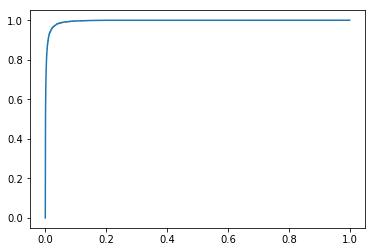

In [16]:
auc_score,_= classifier.auc_ap_scores(adj)
print('auc_score:{:.4f}'.format(auc_score))
fpr, tpr, thresholds = classifier._roc_curve(adj)

plt.plot(fpr,tpr)
plt.show()

In [17]:
print(embeddings.shape)
from sklearn.manifold import TSNE
tsne =  TSNE(n_components=2, learning_rate=200)
data = tsne.fit_transform(embeddings)

(2708, 128)


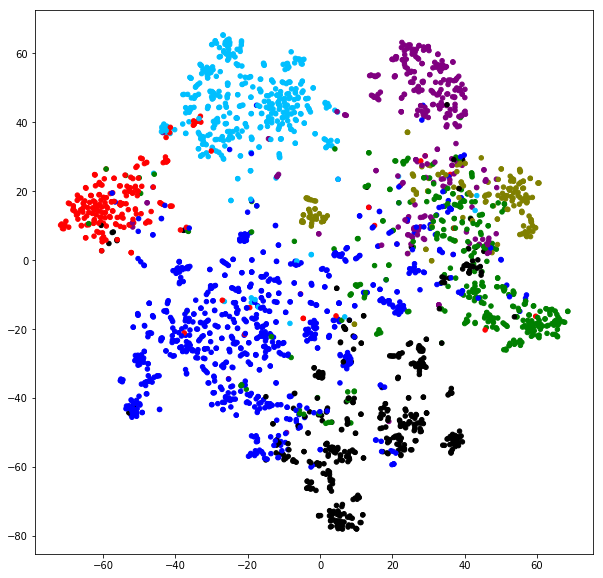

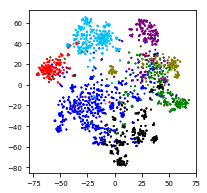

In [18]:


color=[]

C = np.argmax(Y, -1)
for i in range(len(C)):
    
    if C[i] == 0:
        color.append('green')
    if C[i] == 1:
        color.append('red')
    if C[i] == 2:
            color.append('deepskyblue') #blue
    if C[i] == 3:
            color.append('blue')
    if C[i] == 4:
            color.append('black')
    if C[i] == 5:
            color.append('purple')
    if C[i] == 6:
            color.append('olive')        
fig=plt.figure(figsize=(10,10),facecolor='white') #3,3
plt.scatter(data[:,0], data[:,1], s=20,c=color)  #1

fig=plt.figure(figsize=(3,3),facecolor='white') #3,3
plt.tick_params(labelsize=7)
plt.scatter(data[:,0], data[:,1], s=1,c=color)  #1
'''
foo_fig = plt.gcf() # 'get current figure'
foo_fig.savefig('cora.eps', format='eps', dpi=1000)
plt.savefig(args.dataset+'.eps')
'''
#plt.savefig('%s.eps'%args.dataset)
plt.savefig('%s.eps'%args.dataset,format='eps',dpi=1000)
plt.show()    
